# Plots

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

#Import data from src
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

save_dir= "../plots/"

# Load the datasets
file_path = "../data/tickets_data.csv"
train = "../data/train_time_based.csv"
test = "../data/test_time_based.csv"

data = pd.read_csv(file_path)
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

print("\nFirst 5 Rows of the train dataset:")
print(train_df.head())

print("\nTrain dataset Info:")
print(data.info())

print("\nTrain dataset Describe:")
print(data.describe())

print("\nTrain unique Values per Column:")
print(data.nunique())


First 5 Rows of the train dataset:
   Male      Price    From       To  Domestic  \
0     0  13.815511  Shiraz     Yazd         1   
1     1  14.162640  Shiraz  Zahedan         1   
2     1  14.162640  Shiraz  Zahedan         1   
3     1  14.162640  Shiraz  Zahedan         1   
4     1  13.629181  Tehran    Rasht         1   

                                         VehicleType  VehicleClass  \
0  VIPمانیتوردار-شارژر شخصی  تخت شو-پذیرایی-  هر ...             1   
1  اسکانیامارال کلاسیک تک صندلی (جدید)هر پنج سفر ...             1   
2  اسکانیامارال کلاسیک تک صندلی (جدید)هر پنج سفر ...             1   
3  اسکانیامارال کلاسیک تک صندلی (جدید)هر پنج سفر ...             1   
4                                      25 نفره (VIP)             1   

   TripReason  Vehicle  Cancel  LeadTime_Days  Has_Discount  MonthDeparture  \
0           0        0       0       0.121696             0               1   
1           1        0       0       0.759619             0               2   
2          

## Scatterplot (data quality)

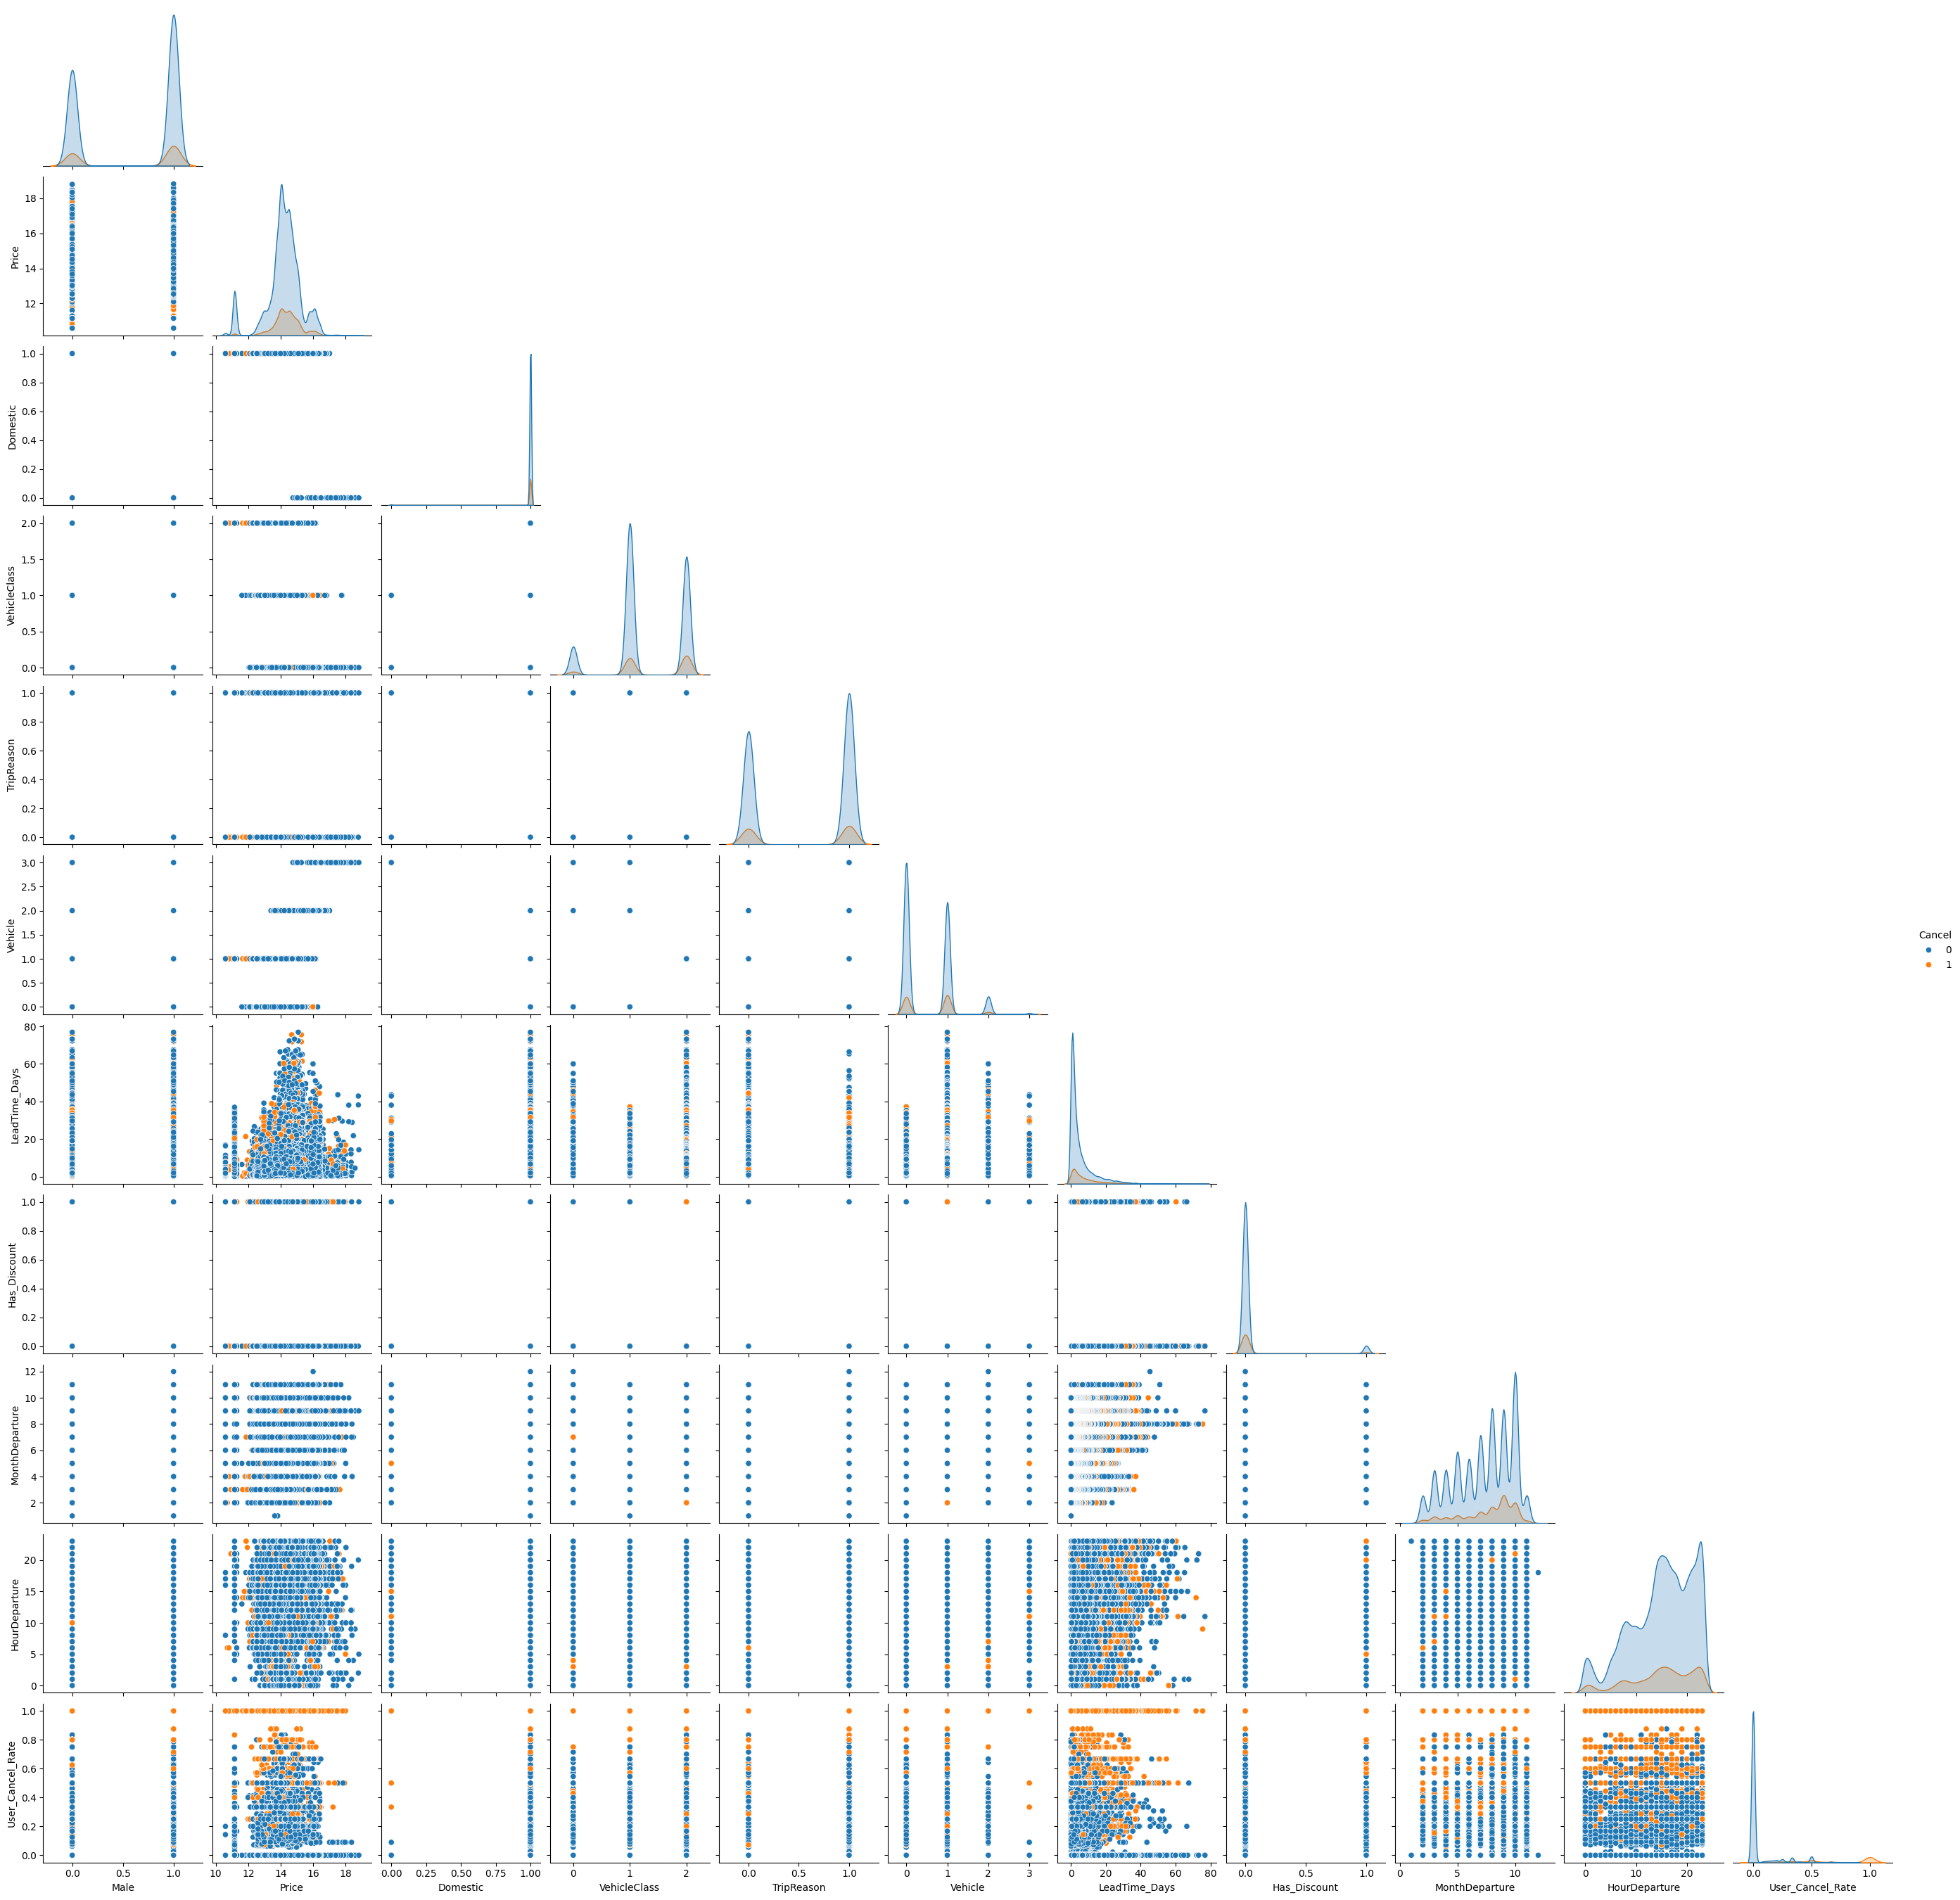

In [3]:
cols_to_plot = ['Male','Price','Domestic','VehicleClass','TripReason','Vehicle','LeadTime_Days','Has_Discount','MonthDeparture','HourDeparture','User_Cancel_Rate']
# other vars: 'From','To','VehicleType',,'User_Total_Tickets'

# Create the plot
# hue='Cancel': Colors the points based on whether they canceled (0=Blue, 1=Orange)
# corner=True:  Removes the redundant upper-right triangle (cleaner look)
sns.pairplot(train_df[cols_to_plot + ['Cancel']], hue='Cancel', corner=True)

plt.savefig(os.path.join(save_dir, "scatter_data.png"))
plt.show()

Orange = cancelled; Blue = non cancelled
1. `User_Cancel_Rate`. The diagonal plot confirms that past history is your best predictor. Most non-cancellers have a 0 rate. People who cancel often have a higher rate.The Scatterplots: Look at the row where User_Cancel_Rate is the Y-axis. You see vertical "stripes" of orange rising higher than the blue. This means as this rate goes up, the likelihood of being an "Orange" point (cancellation) increases drastically.
2. `ReserveStatus`. This shows some separation, lower statuses have very few Orange dots compared to others.
3. `LeadTime_Days`. There is a correlation between booking far in advance and cancelling: people who book tickets months ahead are more likely to have plans change than those booking for immediate travel.
4. `Domestic`. This variable appears highly unbalanced, with almost all data points concentrated at 1.0. It may not hold much predictive power if there is essentially no variance.
5. `TripReason`. The separation between Blue and Orange seems relatively consistent across this category, suggesting that the reason for the trip might not be the primary driver of cancellations compared to user history or lead time.
6. `VehicleClass`: check for discrepancies
7. `HourDeparture` and `MonthDeparture`. Look at `HourDeparture` vs `LeadTime_Days`: you see a big, messy cloud of blue with orange sprinkled inside. Interpretation: There is no clear linear relationship here. Knowing the hour of departure doesn't immediately tell you if someone will cancel. The model will struggle to use these features individually, though they might work in combination with others.

Visualization: Since many variables are categorical, a Correlation Heatmap or a series of Box Plots would likely be more informative than a scatterplot matrix for those specific features.

## Barcharts (predictive power)
### Continuous variables

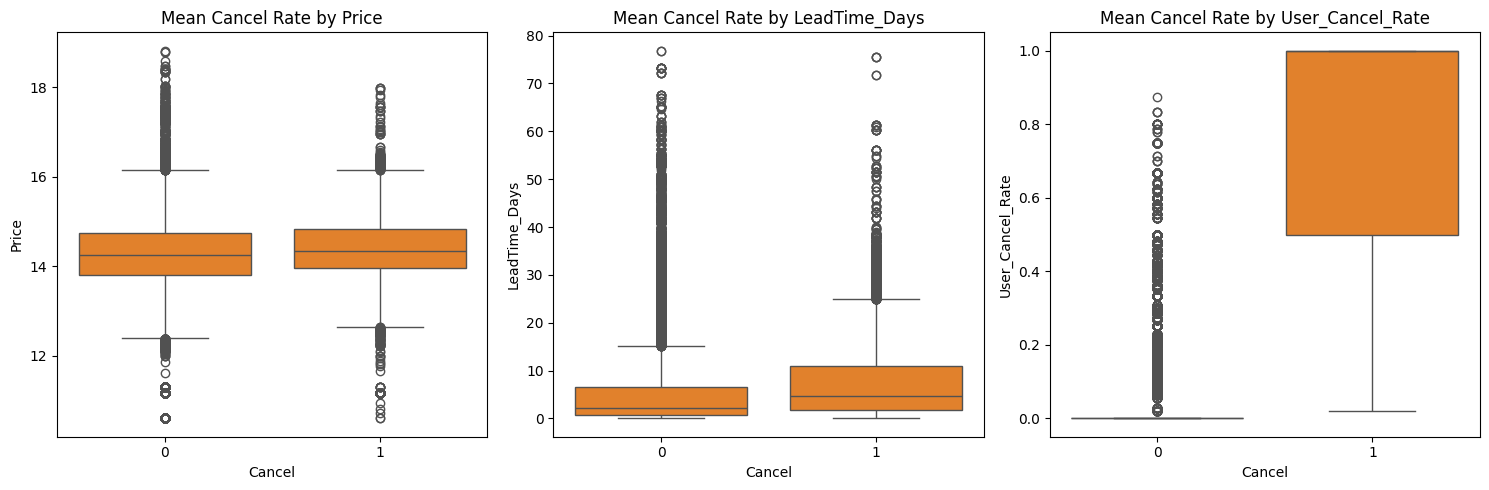

In [4]:
cont_cols_to_plot = ['Price','LeadTime_Days','User_Cancel_Rate']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Flatten the axes array to make it easier to iterate over (converts 2D array to 1D)
axes = axes.flatten()

for i, col in enumerate(cont_cols_to_plot):
    sns.boxplot(x='Cancel', y=col, data=train_df, ax=axes[i], color="tab:orange")
    axes[i].set_title(f'Mean Cancel Rate by {col}')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "boxplot_data.png"))
plt.show()


**Results:**
- `User_Cancel_Rate`: This is our strongest predictor by far.
- `LeadTime_Days`: The median line for Cancelled trips is noticeably higher than for Non-Cancelled. The "whiskers" (the vertical lines) also extend much further up for the Cancelled group. It follows that people who book far in advance are more likely to cancel. Last-minute bookings (low lead time) are "stickier" and less likely to change.

### Categorical variables

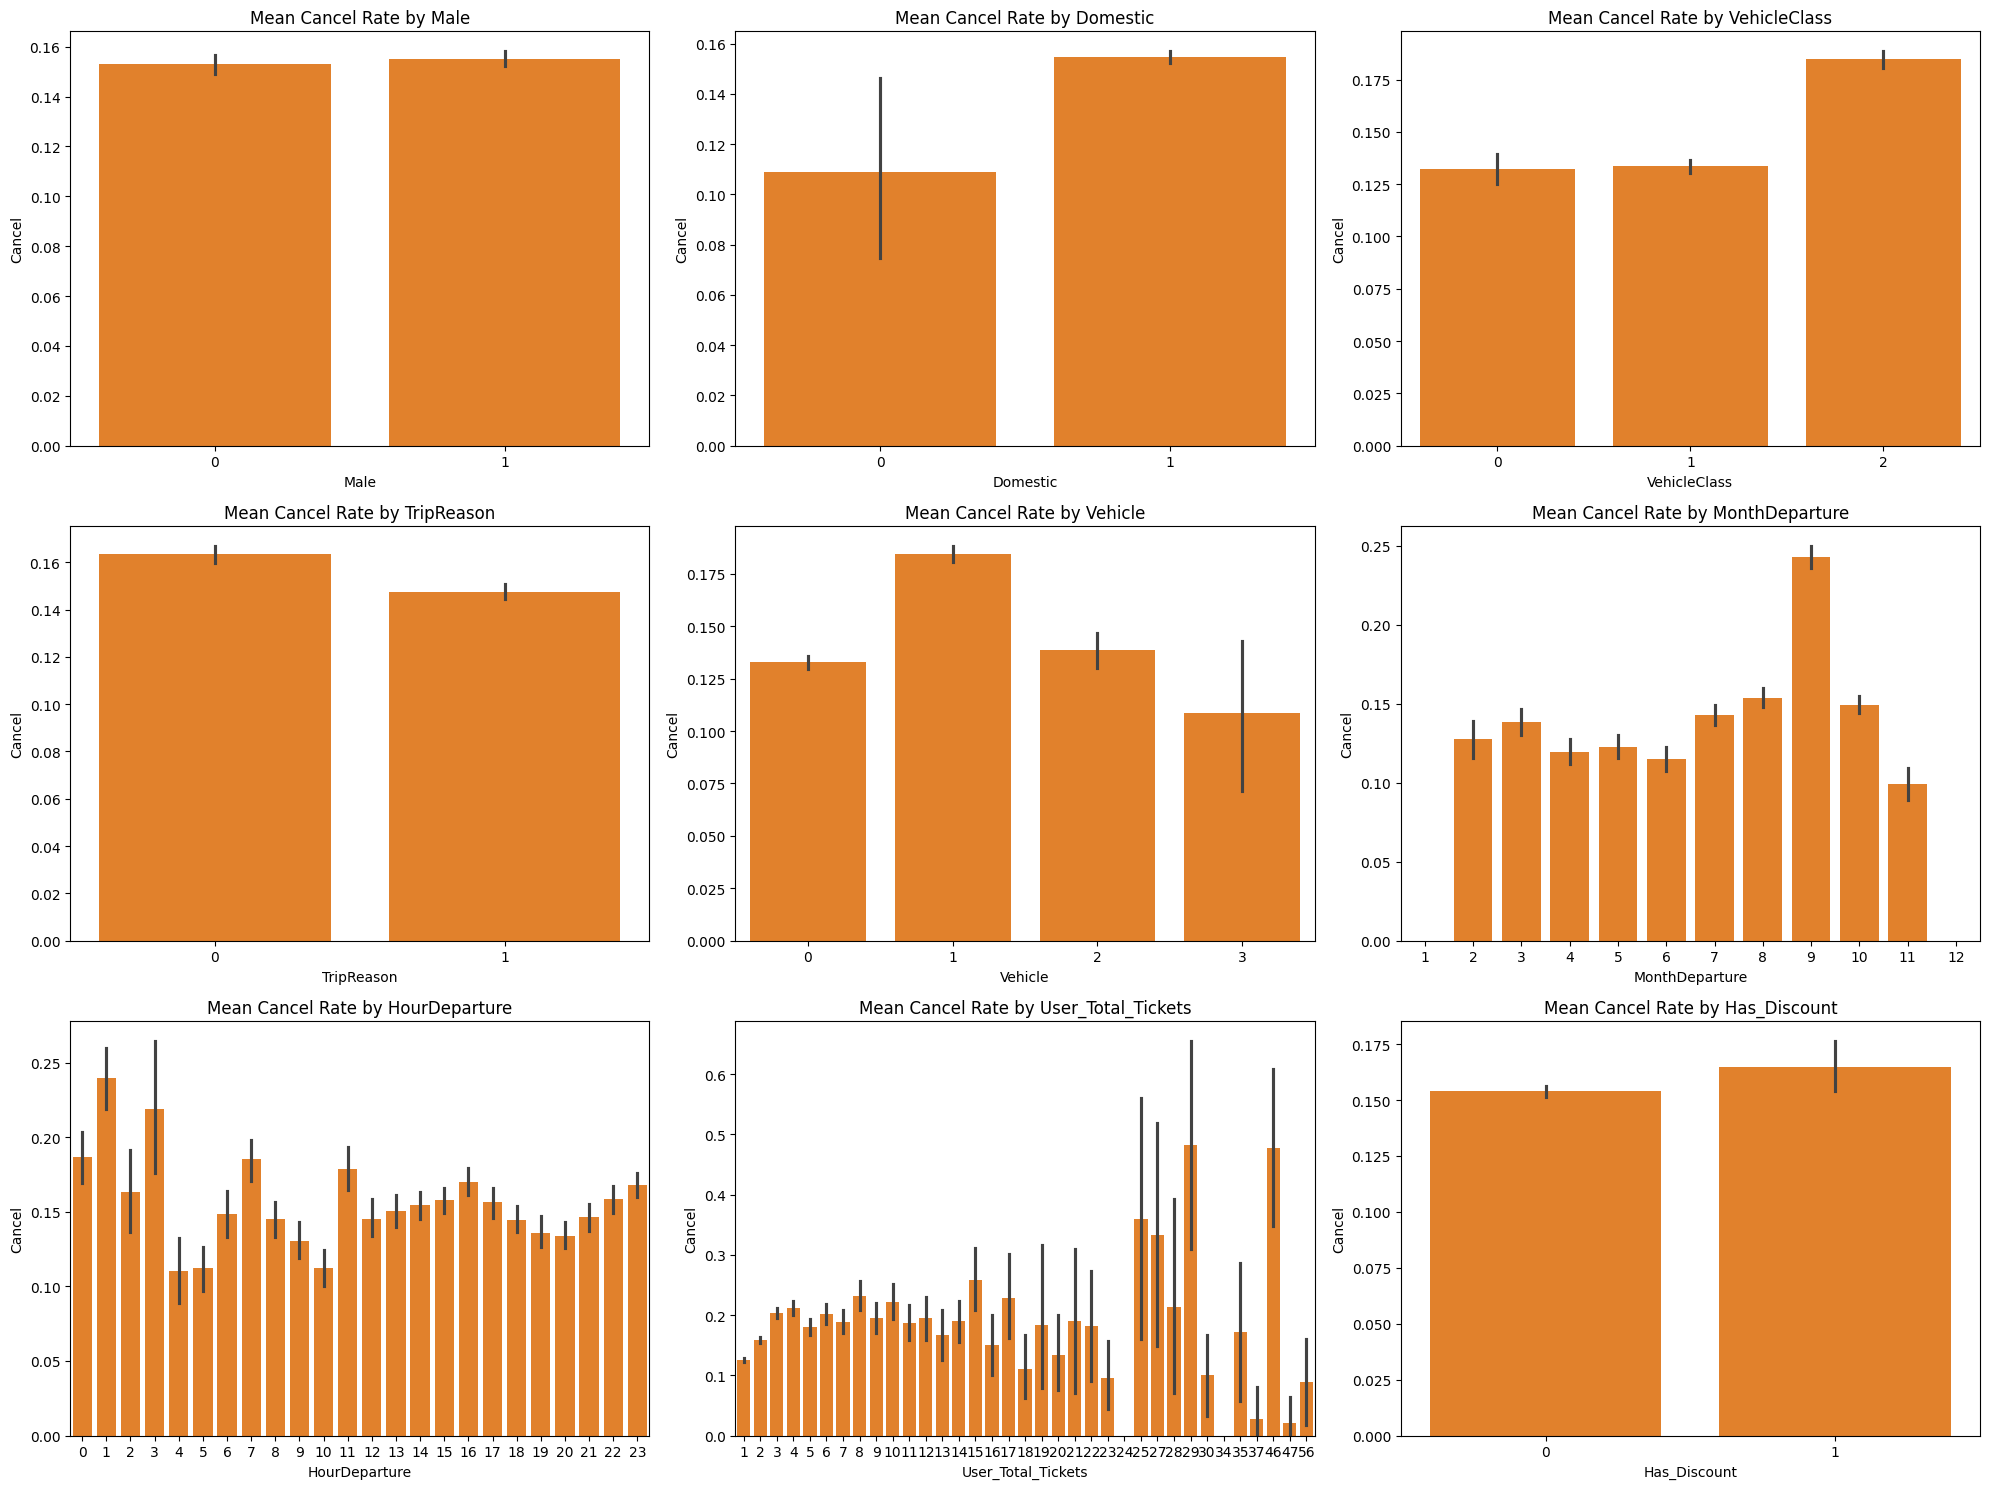

In [5]:
cat_cols_to_plot = ['Male','Domestic','VehicleClass','TripReason','Vehicle','MonthDeparture','HourDeparture','User_Total_Tickets', 'Has_Discount']

#TRAIN SET
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Flatten the axes array to make it easier to iterate over (converts 2D array to 1D)
axes = axes.flatten()

for i, col in enumerate(cat_cols_to_plot):
    sns.barplot(x=col, y='Cancel', data=train_df, ax=axes[i], color="tab:orange")
    axes[i].set_title(f'Mean Cancel Rate by {col}')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "barplot_data.png"))
plt.show()

### Normalized Bar Charts

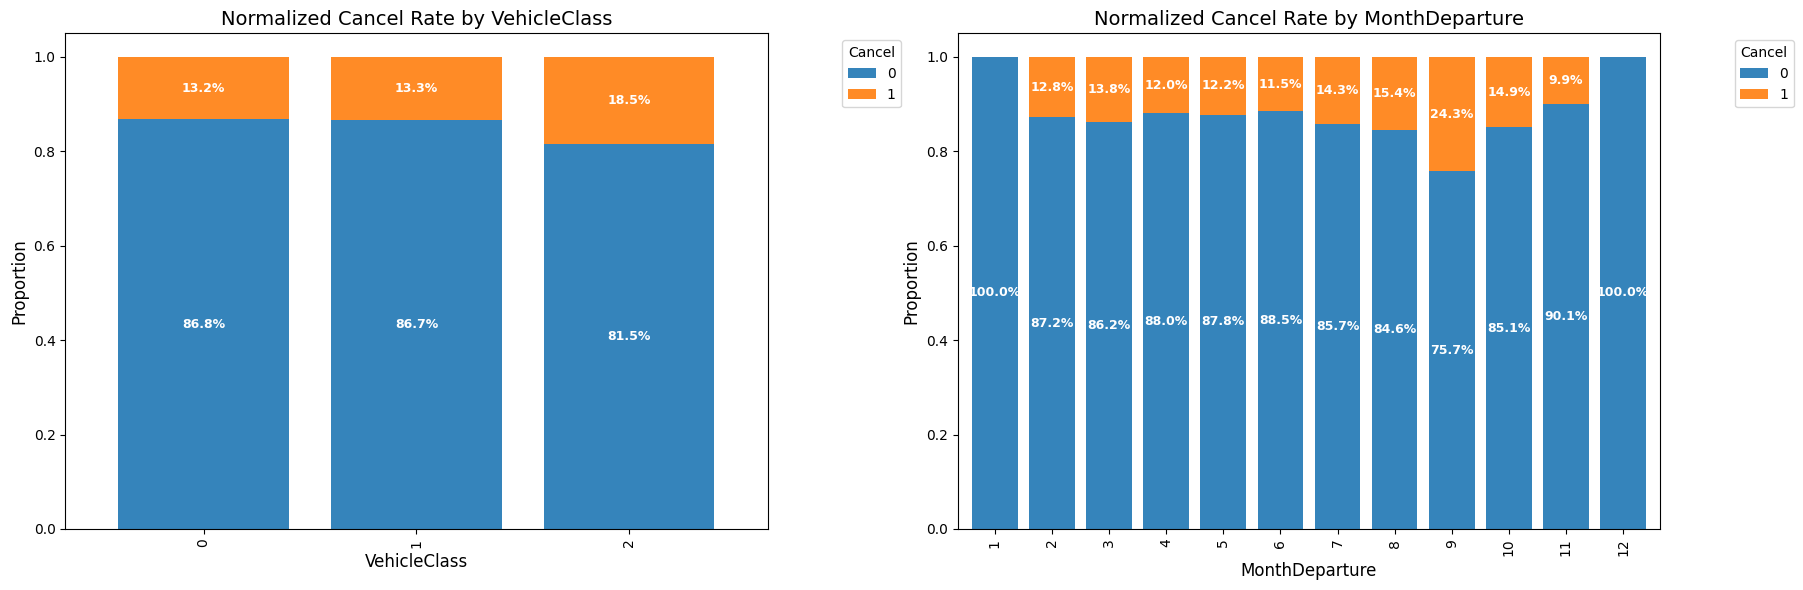

In [6]:

def plot_normalized_stacked_bar(data, x_col, y_col, ax=None):
    """
    Plots a 100% stacked bar chart to visualize the ratio of cancellations.
    """
    # Create Cross-Tabulation and Normalize by Index (Row)
    # This converts counts into Proportions (0.0 to 1.0)
    crosstab = pd.crosstab(data[x_col], data[y_col], normalize='index')
    
    # Create the Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    crosstab.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange'], ax=ax, alpha=0.9, width=0.8)
    
    # Formatting
    ax.set_title(f'Normalized Cancel Rate by {x_col}', fontsize=14)
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_xlabel(x_col, fontsize=12)
    ax.legend(title='Cancel', loc='upper right', bbox_to_anchor=(1.2, 1))
    
    # Annotate Percentages on the bars
    for n, x in enumerate([*crosstab.index.values]):
        for (proportion, y_loc) in zip(crosstab.loc[x], crosstab.loc[x].cumsum()):
            # Only write text if the segment is large enough
            if proportion > 0.03: 
                ax.text(x=n, y=y_loc - (proportion / 2), 
                        s=f'{proportion*100:.1f}%', 
                        color='white', ha='center', va='center', fontweight='bold', fontsize=9)


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: VehicleClass
plot_normalized_stacked_bar(train_df, 'VehicleClass', 'Cancel', ax=axes[0])

# Plot 2: MonthDeparture
plot_normalized_stacked_bar(train_df, 'MonthDeparture', 'Cancel', ax=axes[1])

plt.tight_layout()
plt.show()